# Part 5: Advanced Machine Learning Models
<b>Author</b>: Sterling Cutler
<br>
<b>Date</b>: March 24, 2018

## Boosting, Bagging, and Ensemble Methods
Link: https://quantdare.com/what-is-the-difference-between-bagging-and-boosting/

#### work in progress

In [1]:
# Load dataset
df <- read.csv("ABI_data.csv")

# Train/test split
train_ind <- sample(nrow(df), size=round(nrow(df)*0.8), replace=FALSE)
x_train <- data.matrix(df[train_ind, 1:6])
x_test <- data.matrix(df[-train_ind, 1:6])
y_train <- df[train_ind, 7]
y_test <- df[-train_ind, 7]

# Print data shapes
cat('Train Data Shape:', dim(x_train), "\n")
cat('Test Data Shape:', dim(x_test))

Train Data Shape: 1071 6 
Test Data Shape: 268 6

## Gradient Boosting Machine (GBM)
Link: https://medium.com/mlreview/gradient-boosting-from-scratch-1e317ae4587d

#### work in progress

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.8625             nan     0.5000    0.4018
     2        1.7475             nan     0.5000    0.1067
     3        1.6340             nan     0.5000    0.1064
     4        1.5986             nan     0.5000    0.0289
     5        1.5682             nan     0.5000    0.0144
     6        1.5563             nan     0.5000    0.0022
     7        1.5449             nan     0.5000   -0.0071
     8        1.5411             nan     0.5000   -0.0094
     9        1.5419             nan     0.5000   -0.0370
    10        1.5288             nan     0.5000    0.0142
    20        1.5070             nan     0.5000   -0.0073
    40        1.4972             nan     0.5000   -0.0052
    60        1.4787             nan     0.5000   -0.0036
    80        1.4717             nan     0.5000   -0.0123
   100        1.4674             nan     0.5000   -0.0102



,var,rel.inf
NORM_CLMAGE,NORM_CLMAGE,44.7263246
ATTORNEY,ATTORNEY,41.2830146
MARITAL,MARITAL,7.4695536
CLMSEX,CLMSEX,3.3687662
SEATBELT,SEATBELT,2.5010612
CLMINSUR,CLMINSUR,0.6512798


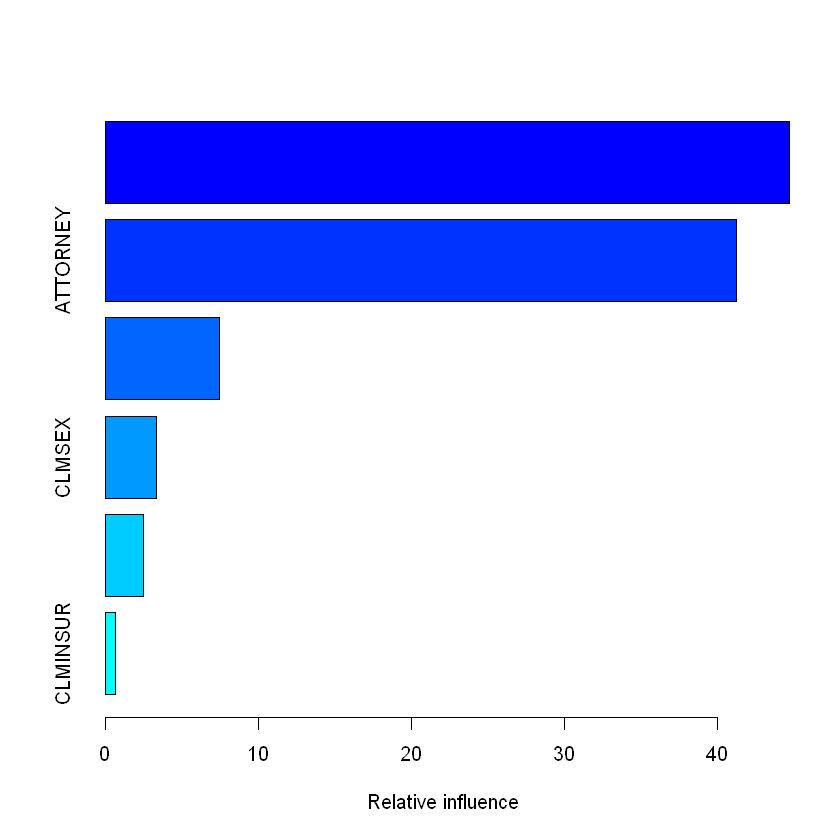

In [2]:
suppressMessages(library(gbm))

# Fit GBM model and print summary
gbm <- gbm.fit(x_train, y_train, distribution="gaussian", n.trees=100,
           shrinkage=0.5, bag.fraction=0.5)
summary(gbm)

Warning message in gbm.perf(gbm, method = "OOB"):
"OOB generally underestimates the optimal number of iterations although predictive performance is reasonably competitive. Using cv.folds>0 when calling gbm usually results in improved predictive performance."

[1] "Best iteration: 11"

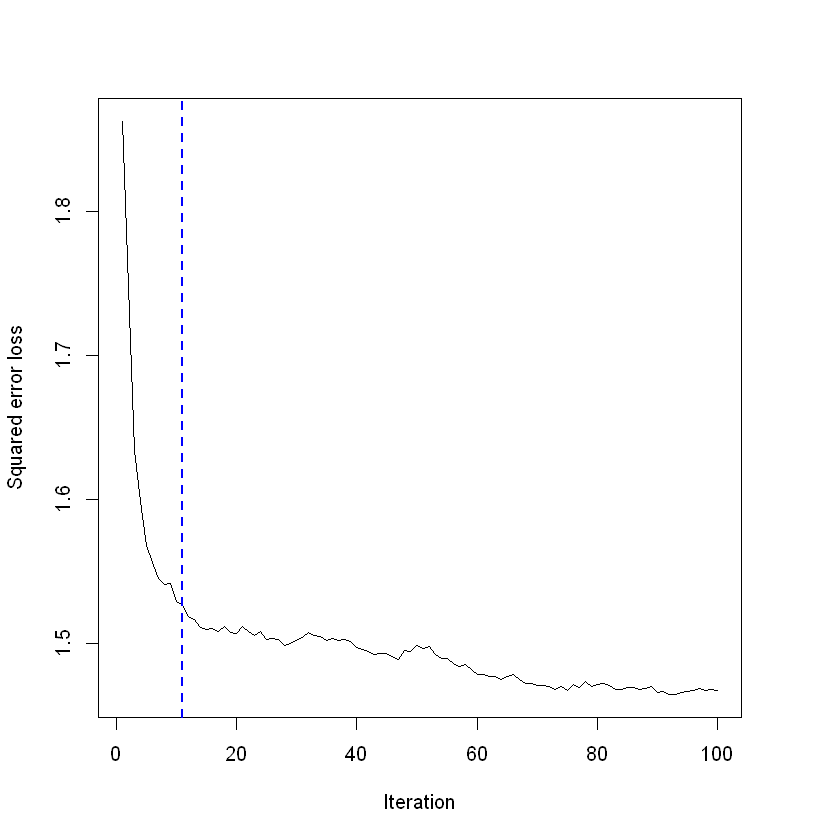

,var,rel.inf
ATTORNEY,ATTORNEY,68.581793
NORM_CLMAGE,NORM_CLMAGE,28.155649
SEATBELT,SEATBELT,3.262558
CLMSEX,CLMSEX,0.000000
MARITAL,MARITAL,0.000000
CLMINSUR,CLMINSUR,0.000000


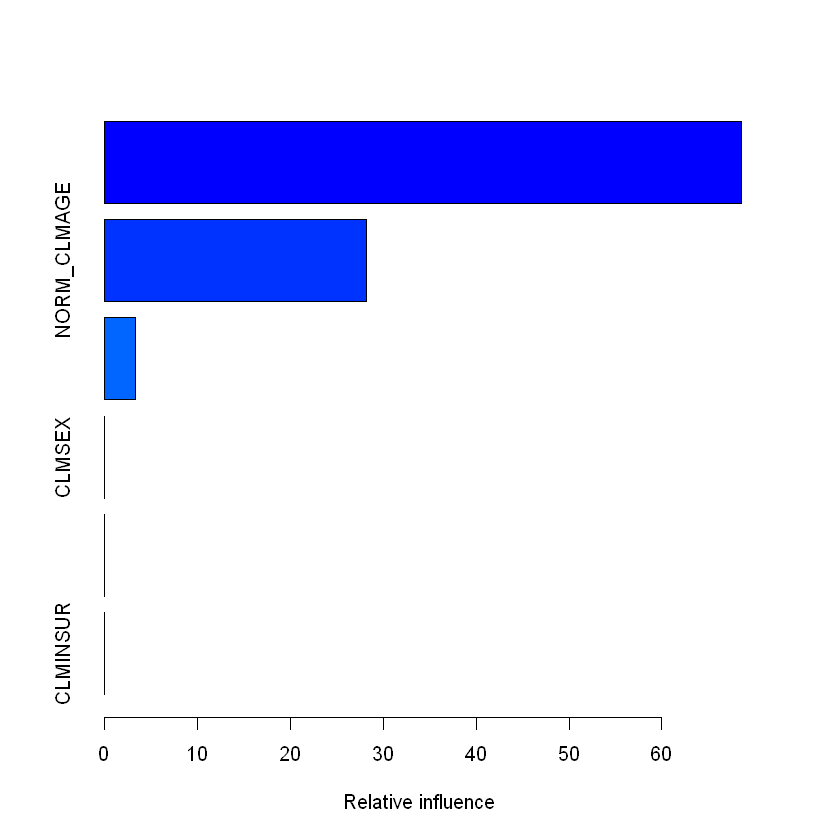

In [3]:
# Use out-of-bag estimator (OOB) to find optimal number of iterations
best_iter <- gbm.perf(gbm, method="OOB")
paste("Best iteration:", best_iter)
summary(gbm, n.trees=best_iter)

In [4]:
suppressWarnings(library(Metrics))

# Predict target for test data
gbm_preds <- predict(gbm, x_test, best_iter)
paste("GBM RMSE:", round(rmse(y_test, gbm_preds), 4))

[1] "GBM RMSE: 1.0863"

## Random Forest

#### work in progress

In [5]:
suppressMessages(library(randomForest))

# Fit Random Forest model and view model summary
rf_model <- randomForest(x_train, y_train, x_test, y_test, ntree=500)
print(rf_model)


Call:
 randomForest(x = x_train, y = y_train, xtest = x_test, ytest = y_test,      ntree = 500) 
               Type of random forest: regression
                     Number of trees: 500
No. of variables tried at each split: 2

          Mean of squared residuals: 1.564344
                    % Var explained: 30.46
                       Test set MSE: 1.23
                    % Var explained: 30.67


In [6]:
# Tune model parameters with cross validation
rf_cv <- rfcv(x_train, y_train, cv.fold=5)
paste(rf_cv$n.var, rf_cv$error.cv)

[1] "6 1.58429641787761" "3 1.57011017650228" "1 1.72842308375844"

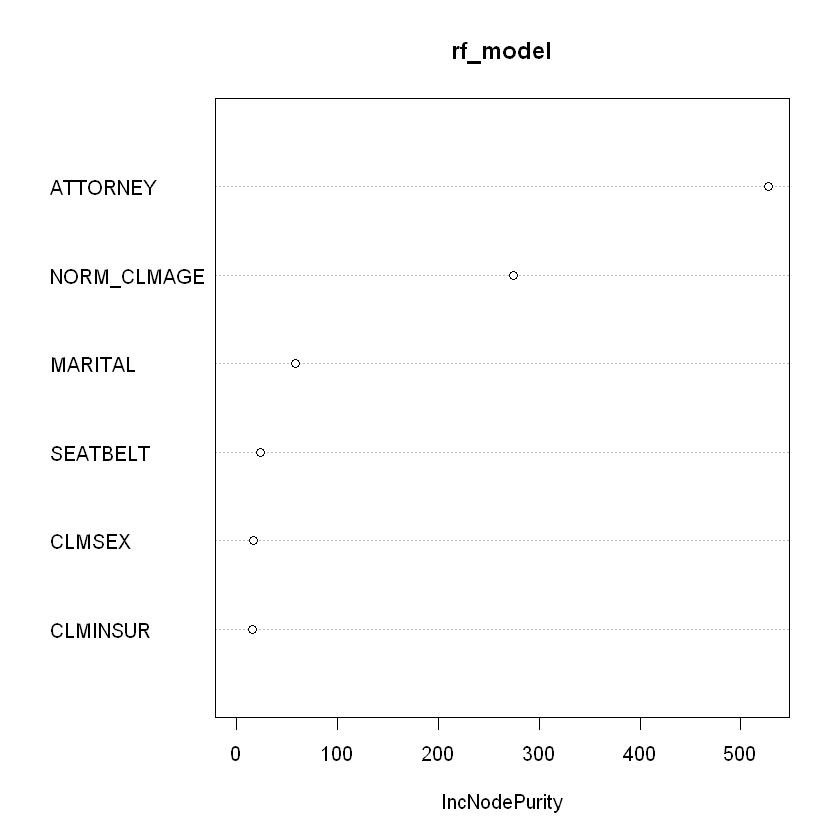

In [7]:
# Plot variable importance
varImpPlot(rf_model, sort=TRUE)

In [8]:
# Make model predictions against test data
rf_model2 <- randomForest(x_train, y_train, x_test, y_test, ntree=500, mtry=3, keep.forest=TRUE)
rf_preds <- predict(rf_model2, x_test)
paste("RandomForest RMSE:", round(rmse(y_test, rf_preds), 4))

[1] "RandomForest RMSE: 1.1476"

## XGBOOST
Link: http://xgboost.readthedocs.io/en/latest/model.html#objective-function-training-loss-regularization

Versus GBM:
- Adds regularization term that helps model avoid overfitting
- Other hardware/computational benefits

#### work in progress

In [9]:
library(xgboost)

# Fit model to training data
dtrain <- xgb.DMatrix(x_train, label=y_train)
cntrl = list(eta=0.01, max_depth=3, gamma=0.3)
xgb <- xgb.train(params=cntrl, data=dtrain, nrounds=500)

In [10]:
# Find number of rounds with cross validation
cv <- xgb.cv(data=dtrain, nrounds=10, nfold=5, metrics="rmse", objective="reg:linear")
print(cv)

[1]	train-rmse:1.347913+0.008022	test-rmse:1.380803+0.033485 
[2]	train-rmse:1.259968+0.006047	test-rmse:1.322579+0.027855 
[3]	train-rmse:1.205920+0.007300	test-rmse:1.294853+0.029368 
[4]	train-rmse:1.170567+0.006580	test-rmse:1.282010+0.029056 
[5]	train-rmse:1.147813+0.008437	test-rmse:1.281277+0.026704 
[6]	train-rmse:1.131539+0.008752	test-rmse:1.284291+0.026284 
[7]	train-rmse:1.117117+0.010963	test-rmse:1.287854+0.027408 
[8]	train-rmse:1.105062+0.012578	test-rmse:1.294920+0.029172 
[9]	train-rmse:1.096223+0.011898	test-rmse:1.296898+0.030535 
[10]	train-rmse:1.088055+0.009963	test-rmse:1.300770+0.033431 
##### xgb.cv 5-folds
 iter train_rmse_mean train_rmse_std test_rmse_mean test_rmse_std
    1        1.347913    0.008022137       1.380803    0.03348468
    2        1.259968    0.006046821       1.322579    0.02785495
    3        1.205920    0.007300221       1.294853    0.02936761
    4        1.170567    0.006579842       1.282010    0.02905632
    5        1.147813    0.0

       Feature        Gain       Cover  Frequency
1:    ATTORNEY 0.618168632 0.215374605 0.10366032
2: NORM_CLMAGE 0.322502180 0.580265116 0.60497804
3:     MARITAL 0.036615406 0.077137022 0.14582723
4:    SEATBELT 0.016286166 0.115747561 0.07525622
5:      CLMSEX 0.004340028 0.008988911 0.05212299
6:    CLMINSUR 0.002087589 0.002486785 0.01815520


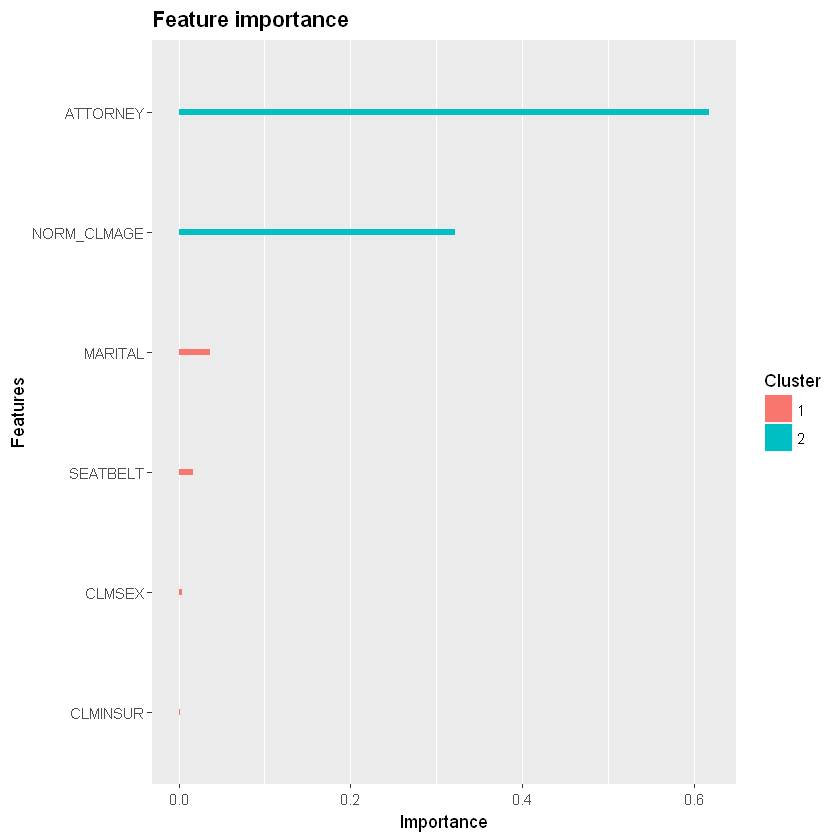

In [11]:
suppressMessages(library(ggplot2))

# Show and plot feature importance
importances <- xgb.importance(colnames(x_train), xgb)
print(importances)
xgb.ggplot.importance(importances)

In [12]:
# Fit better model based on parameter experimentation
cntrl = list(eta=0.01, max_depth=2, alpha=1.0, gamma=1.0)
xgb <- xgb.train(params=cntrl, data=dtrain, nrounds=1000)

In [13]:
# Make model predictions against test data
xgb_preds <- predict(xgb, x_test)
paste("XGBoost RMSE:", round(rmse(y_test, xgb_preds), 4))

[1] "XGBoost RMSE: 1.0981"

## Final Note: Distributed Modeling
Sometimes datasets are too large to model on a single machine in a stable and timely manner.
#### work in progress

## Sources
